In [10]:
from utils.db import load_all_rows_from_mongo
from utils.functions import processar_indicadores_financeiros
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
#from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
all_rows = load_all_rows_from_mongo(coll_name="industrial_nordeste")

df_hist = pd.DataFrame(all_rows)
indicadores_historicos = processar_indicadores_financeiros(df_hist)

In [ ]:
indicadores_historicos

In [4]:
resultado = adfuller(indicadores_historicos['Lucro_Líquido'])
p_valor = resultado[1]

print(f"p-valor: {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série é estacionária (rejeita H₀).")
else:
    print("⚠️ A série NÃO é estacionária (não rejeita H₀). O Prophet consegue lidar com isso.")

p-valor: 0.0054
✅ A série é estacionária (rejeita H₀).


In [8]:
lb = acorr_ljungbox(indicadores_historicos['Lucro_Líquido'], lags=[3], return_df=True)
p_valor = lb['lb_pvalue'].iloc[-1]  # pega o p-valor do último lag

print(lb)
print(f"\nP-valor (lag 12): {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série apresenta autocorrelação significativa (rejeita H₀).")
else:
    print("⚠️ A série NÃO apresenta autocorrelação significativa (não rejeita H₀).")

    lb_stat  lb_pvalue
3  9.773419   0.020594

P-valor (lag 12): 0.0206
✅ A série apresenta autocorrelação significativa (rejeita H₀).


<Figure size 1000x400 with 0 Axes>

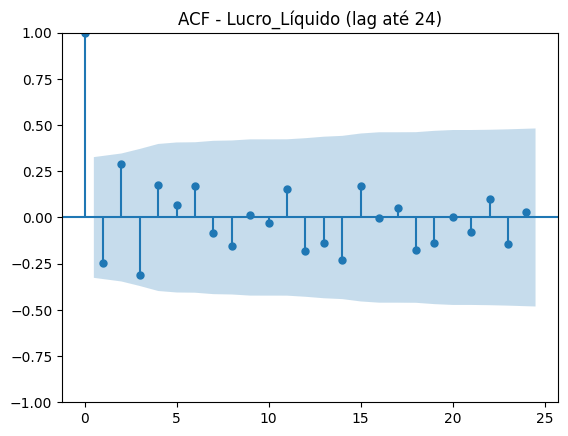

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 24 must be < 18.

<Figure size 1000x400 with 0 Axes>

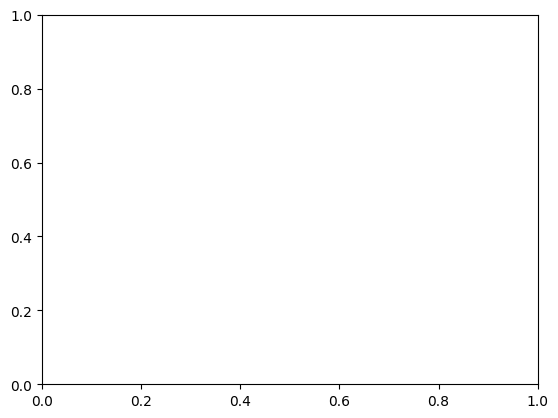

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 4))
# alpha para bandas de conf.
plot_acf(indicadores_historicos['Lucro_Líquido'], lags=24, alpha=0.05)
plt.title("ACF - Lucro_Líquido (lag até 24)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(indicadores_historicos['Lucro_Líquido'],
          lags=24, alpha=0.05, method='ywm')
plt.title("PACF - Lucro_Líquido (lag até 24)")
plt.show()

In [ ]:
m = Prophet(yearly_seasonality=True,
            monthly_seasonality=False, daily_seasonality=False)
m.fit(indicadores_historicos["Lucro_Líquido"])

# Gerar previsões para 12 meses à frente
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Visualizar
m.plot(forecast)
m.plot_components(forecast)

TypeError: __init__() got an unexpected keyword argument 'monthly_seasonality'